<h1>Helvar Challenge 2</h1>
<h3>Welcome to our attempt at the challenge!</h3>
<p>This notebook presents our attempt at a solution for the challenge.</p>
<p>Solution allows user to analyze space usage with sensor activation frequecy.</p>
<p>Slider has frequency scale in hours</p>
<p>How is this usefull? User has to find that out! We just throw fft at the problem</p>
<p>Let's Begin by first loading all necessary libraries for this notebook to run.</p>

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import base64
import json, pickle
from PIL import Image
from plotting import Plotting
import plotly.graph_objects as go
import plotly.subplots as sp

<p>Variables below can be used to load other datasets.</p>
<p>For demo only run everything before "Data-generation" Cell</p>
<p>Repository has already filtered data. Huge datasets take too much time to run everytime, but user can still change datasets</p>

In [2]:
site = 'site_1'

In [3]:
with open(f'./data/{site}/{site}.json') as fl:
    df_devices = json.load(fl)

In [4]:
img = Image.open(f"data/{site}/{site}.png")

In [5]:
n = site.split('_')[1]

fft_data = pd.read_pickle(f"fft-{n}.pkl")
fft_static = pd.read_pickle("fl.pkl")

N = len(fft_static)
n = np.arange(N)
# get the sampling rate
sr = 1 / (60 * 60)
T = N/sr
freq = n/T 

n_oneside = N//2
f_oneside = freq[:n_oneside]

We can now load the floorplan just to get a feel of what the devices look like.


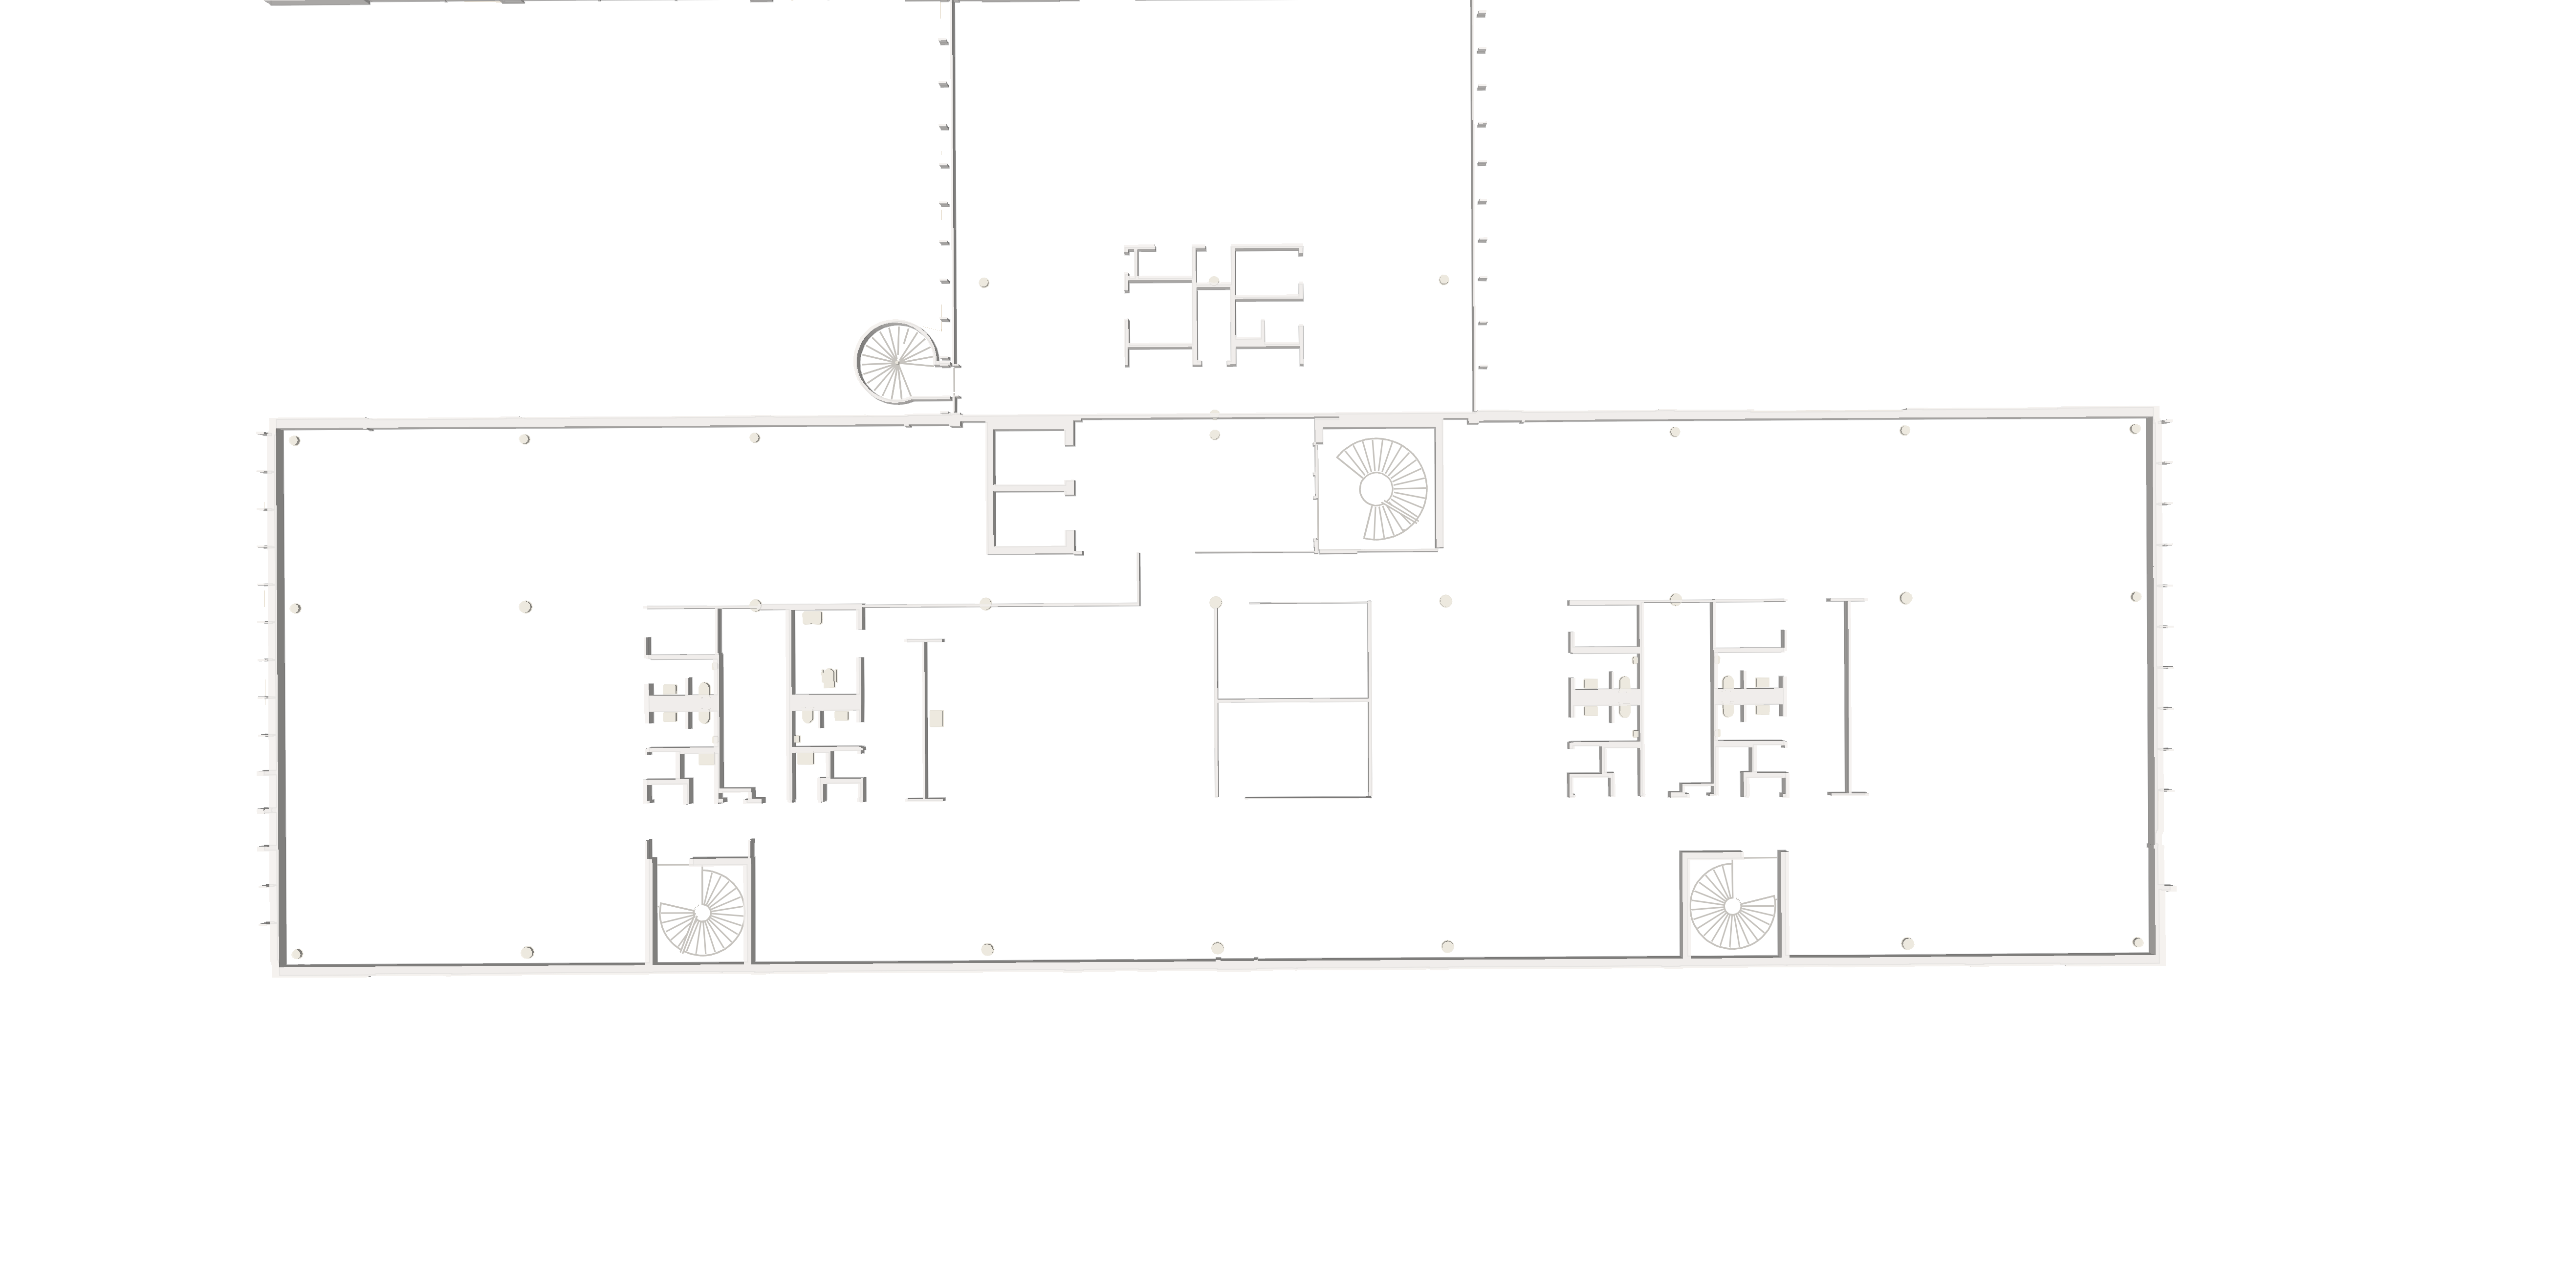

In [7]:
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Frq:",
        "visible": True,
        "xanchor": "right"},
    "steps": []
}
sizes = []
for i in range(256):
    X = []
    Y = []
    amp = []
    for entry in fft_data:
        dev = list(filter(lambda x: x["deviceid"] == entry['deviceid'],df_devices))[0]
        X.append(dev['x'])
        Y.append(dev['y'])
        try:
            amp.append(entry["values"][i]*40)
        except IndexError as e:
            amp.append(0)
                
    data_dict = {
            "x": X,
            "y": Y,
            "mode": "markers",
            "marker": {
                "sizemode": "area",
                "size": amp,
                "color": "red"
            },
    }
    fig_dict["frames"].append({"data":[data_dict],"name": f"{i}"})
    slider_step = {"args": [
        [str(i)],
        {"frame": {"duration": 300, "redraw": True},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": f"{i}",
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)

fig_dict["layout"]["sliders"] = [sliders_dict]
fig_dict["layout"]["images"] = [dict(x=0,sizex=img.width,y=0, sizey=img.height,opacity=1.0,xref="x",yref="y",sizing="stretch",layer="below",source=img)]
fig_dict["data"] = [dict(x=[i["x"] for i in df_devices],y=[i["y"] for i in df_devices],mode="markers")]


fig = go.Figure(fig_dict)
fig.layout.height = img.height/4 # this is for binder, if you're runnuing locally comment this line out
fig.update_xaxes(range=(0, img.width))
fig.update_yaxes(range=(img.height, 0))

## Data Generation
<p>Here we generate our data, this is way too recource intensive to run on our demo site, so please don't. Instead run this locally on your machine after cloning from git. Warning may crash old hardware.</p>

In [ ]:
#Tästä alkaa mun sähellys
import matplotlib.pyplot as plt
import numpy as np
import pickle, tqdm

from numpy.fft import fft, fftshift

def do_magic_fft(i):
    site = f"site_{i}"
    df_events = pd.read_pickle(f'./data/{site}/{site}.pkl', compression='gzip')
    df_events.loc[:, 'timestamp'] = (pd.to_datetime(df_events['timestamp'], utc=True)
                                 .dt.tz_convert('Europe/Helsinki')
                                 .dt.tz_localize(None))
    
    with open(f"fft-{i}.pkl", "wb") as handle:
        ffts = []
        for j in tqdm.tqdm(range(max(df_events['deviceid'])+1)):
            try:
                mask = df_events['deviceid'].isin([j])
                #df_events.loc[mask]
        
                df_events_day = df_events.loc[mask].copy()
                df_events_day.loc[:, 'timestamp'] = df_events_day['timestamp'].dt.floor('1h')
                df_events_day.loc[:, 'value'] = 1.0
                df_events_day = df_events_day.groupby('timestamp').sum()
                df = df_events_day.drop(['deviceid'], axis=1)

                X = fft(df['value'])
                N = len(X)
                n = np.arange(N)

                sr = 1 /(60*60)
                T = N/sr
                freq = n/T 

                n_oneside = N//2 

                f_oneside = freq[:n_oneside] 

                t_h = 1/f_oneside/ (60*60)
                X_a = np.abs(X[:n_oneside])/n_oneside
        
                dat = {"deviceid":j,"values":X_a}
                ffts.append(dat)
            except:
                pass
        pickle.dump(ffts,handle)

for i in range(1,6):
    do_magic_fft(i)
